# Graceful Chain Splitting

In this analysis, we evaluate the scenario of an **irreparable network split**. In this scenario, the network is partitioned into two parts for a very long time. 
During the split, finality is temporarily unreachable in both parts due to an insufficient number of generators committed to generate blocks. 
However, finality is expected to be restored independently in each part after the expiration of old generator commitments.

## How Generator Commitment Works

To become a generator on the Waves blockchain, an account must have a sufficient balance and issue a **Generation Commitment Transaction**. 
This transaction specifies two key parameters: the start height and the end height of the commitment. 

- The **start height** allows generators to submit their commitment transaction in advance.
- The **end height** enforces a mandatory renewal of commitments, ensuring that inactive or unreachable generators are eventually excluded from the generation process.

Additionally, the duration of a commitment is bounded by configurable **lower** and **upper** limits.

## Models

We evaluate two models for the expiration and renewal of generator commitments:

### 1. Synchronized Commitments Model

This model naturally emerges at the moment of the introduction of the commitment mechanism. Since the new functionality will be activated at a specific block height, all active generators will issue their first commitments simultaneously. Therefore, all initial commitment periods will start at the same height.

### 2. Randomized Commitment Starts Model

Over time, the initial synchronization will blur as:
- New generators join and issue commitments at arbitrary times.
- Existing generators may miss commitment renewal deadlines and later re-commit asynchronously.

This results in a model where commitment start times become naturally randomized across the set of generators.

In the following sections, we will analyze how these models impact the restoration of independent finality in the event of a long-term network split.

### Model Explanation

After the network split, the Generators Set is divided into two partitions: $P_1(t)$ and $P_2(t)$.
The number of generators present on both forks after time $t$ is given by:

$I(t) = |P_1(t) \cap P_2(t)|$

Finality becomes possible if:

$I(t) < (1 - f) \cdot N$

where:
- $f$ is the required fraction for finality (e.g., $f = \frac{2}{3}$ in Waves).
- $N$ is the total number of generators.

Once the intersection drops below $\frac{1}{3}$ of generators, the forks become independent in terms of finality, meaning that each can safely finalize its own chain.

Both models will be evaluated using a dataset of real MainNet generator balances as of March 2025. 
This dataset is provided in the `mainnet.generators.parquet` file.

In [33]:
# Imports and common model parameters

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow.parquet as pq

# Charts style
plt.style.use('computermodernstyle.mplstyle')

# Model parameters
min_duration = 10000               # Minimum commitment duration (blocks)
max_duration = 20000               # Maximum commitment duration (blocks)
simulation_time = 25000            # How many blocks to simulate after split
finality_fraction = 2 / 3          # Waves finality threshold (e.g., 2/3)
confidence_target = 0.95           # Required probability to accept finality recovery
num_simulations = 200              # Number of Monte Carlo simulations

# Read generators 
generators_table = pq.read_table("mainnet.generators.parquet")

# Extract generators balances and covert them into stakes
generators = generators_table.to_pandas()
total_generators = len(generators) # Number of generators
total_balance = generators["balance"].sum() # Total generation balance

stakes = generators["balance"]
stakes = stakes / total_balance  # Normalize so total stake = 1.0

# Finality threshold
finality_threshold_stake = 1 - finality_fraction


## Synchronized Commitments Model

> **Note:** The model takes more than 1 minute to complete the calculation.

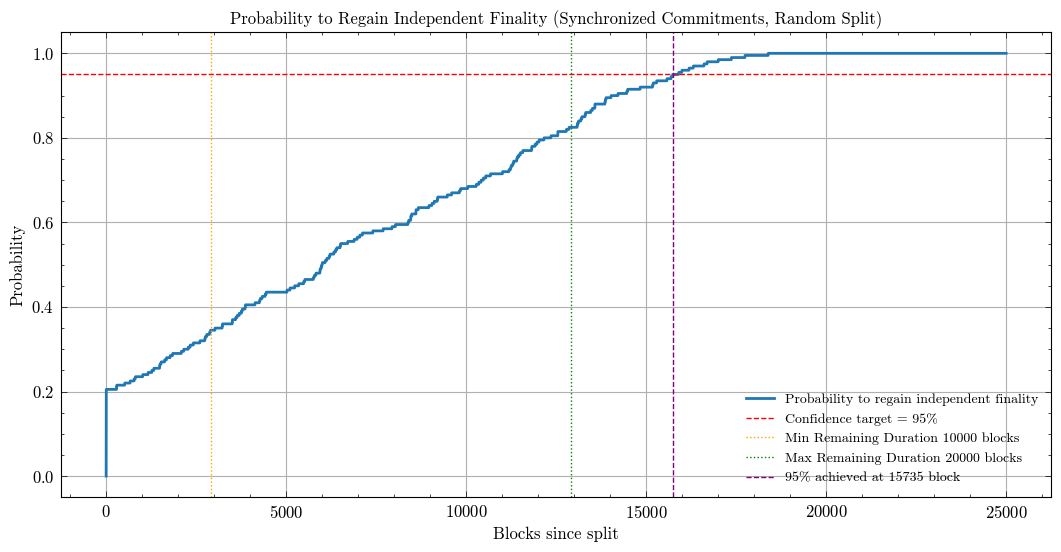

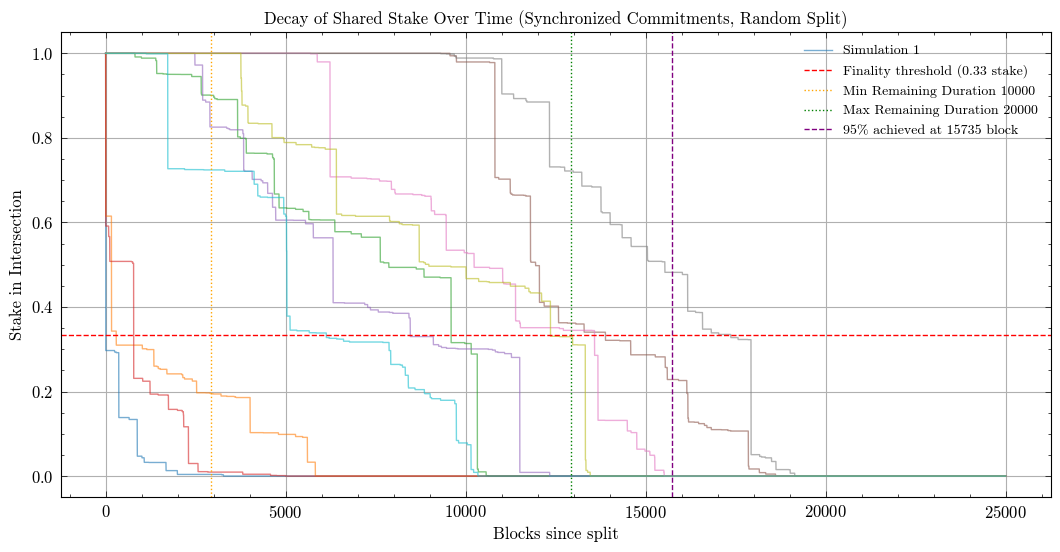

In [34]:
time = np.arange(simulation_time)
intersection_stake_records = np.zeros((num_simulations, simulation_time))

for sim in range(num_simulations):
    # All generators commit at the same time (say block 0)
    # Sample random commitment durations
    commitment_durations = np.random.uniform(min_duration, max_duration, total_generators)
    
    # The network split happens randomly between [0, max_duration)
    split_time = np.random.uniform(0, max_duration)
    # Compute expiration times relative to the split
    
    expiration_times = commitment_durations - split_time  # Remaining time left at split
    
    # Generators who already expired before the split have expiration_times < 0
    expiration_times[expiration_times < 0] = 0

    # For each block after the split, sum stake of active generators
    intersection_stake = []
    for t in time:
        active = expiration_times >= t
        intersection_stake.append(stakes[active].sum())
    intersection_stake_records[sim] = intersection_stake


# Compute probability to regain finality at each block height
prob_finality_restored_stake = np.mean(intersection_stake_records <= finality_threshold_stake, axis=0)

# Find when the probability crosses the confidence_target
crossing_index = np.argmax(prob_finality_restored_stake >= confidence_target)
crossing_block = time[crossing_index] if prob_finality_restored_stake[crossing_index] >= confidence_target else None

# Plot 1: Probability of Independent Finality Recovery
f, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, prob_finality_restored_stake, label="Probability to regain independent finality", linewidth=2)
ax.axhline(confidence_target, color='red', linestyle='--', label=f"Confidence target = {confidence_target * 100:.0f}%")
ax.axvline(min_duration - split_time, color='orange', linestyle=':', label=f"Min Remaining Duration {min_duration} blocks")
ax.axvline(max_duration - split_time, color='green', linestyle=':', label=f"Max Remaining Duration {max_duration} blocks")
if crossing_block is not None:
    ax.axvline(crossing_block, color='purple', linestyle='--', label=f"95% achieved at {crossing_block} block")
ax.set_xlabel("Blocks since split")
ax.set_ylabel("Probability")
ax.set_title("Probability to Regain Independent Finality (Synchronized Commitments, Random Split)")
ax.legend()
ax.grid(True)
plt.savefig("probability_1.png", dpi=300)

# Plot 2: Stake Intersection Decay Over Time
f, ax = plt.subplots(figsize=(12, 6))

# Plot a few sample simulations
for i in range(min(10, num_simulations)):
    ax.plot(time, intersection_stake_records[i], alpha=0.6, label=f"Simulation {i+1}" if i == 0 else "")

ax.axhline(finality_threshold_stake, color='red', linestyle='--', label=f"Finality threshold ({finality_threshold_stake:.2f} stake)")
ax.axvline(min_duration - split_time, color='orange', linestyle=':', label=f"Min Remaining Duration {min_duration}")
ax.axvline(max_duration - split_time, color='green', linestyle=':', label=f"Max Remaining Duration {max_duration}")
if crossing_block is not None:
    ax.axvline(crossing_block, color='purple', linestyle='--', label=f"95% achieved at {crossing_block} block")
ax.set_xlabel("Blocks since split")
ax.set_ylabel("Stake in Intersection")
ax.set_title("Decay of Shared Stake Over Time (Synchronized Commitments, Random Split)")
ax.legend()
ax.grid(True)
plt.savefig("decay_1.png", dpi=300)

## Randomized Commitment Starts Model

> **Note:** The model takes more than 1 minute to complete the calculation.

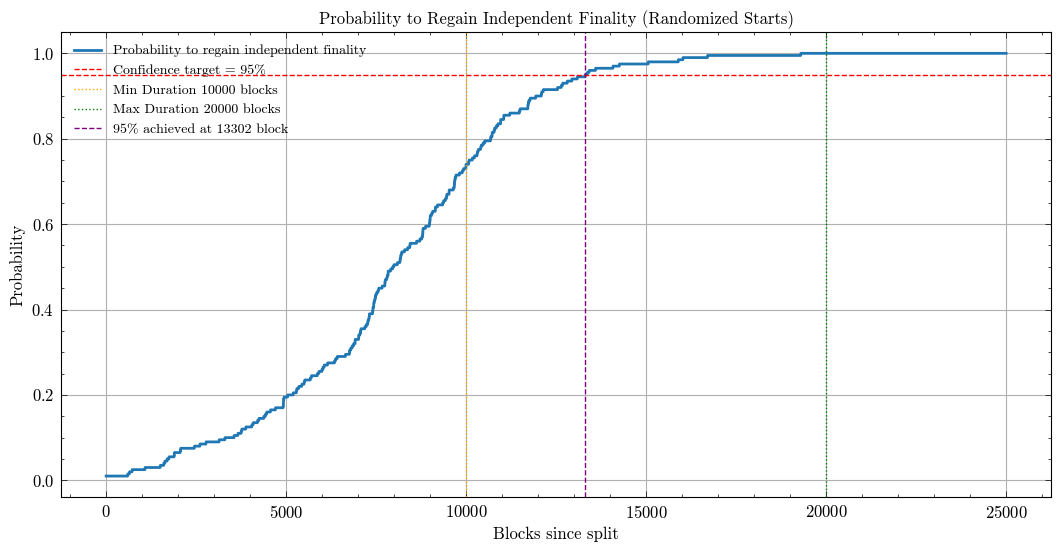

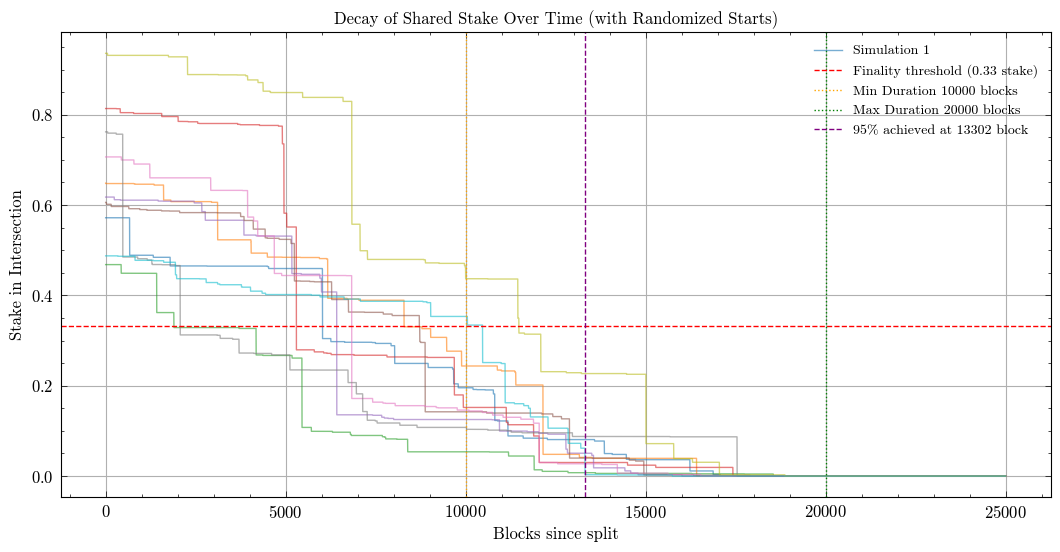

In [35]:

# Simulation
time = np.arange(simulation_time)
intersection_stake_records = np.zeros((num_simulations, simulation_time))

# Prepare last simulation's expiration_times for the expiration distribution plot
last_expiration_times = None

for sim in range(num_simulations):
    # Sample random commitment start times uniformly from [-max_duration, 0]
    start_times = np.random.uniform(-max_duration, 0, total_generators)
    # Sample random durations
    commitment_durations = np.random.uniform(min_duration, max_duration, total_generators)
    # Compute expiration times
    expiration_times = start_times + commitment_durations  # relative to t=0 (split)
    
    if sim == num_simulations - 1:
        last_expiration_times = expiration_times.copy()

    # For each block, sum stake of active generators
    intersection_stake = []
    for t in time:
        active = expiration_times >= t
        intersection_stake.append(stakes[active].sum())
    intersection_stake_records[sim] = intersection_stake

# Finality threshold
finality_threshold_stake = 1 - finality_fraction  # e.g., 1 - 2/3 = 1/3

# Compute probability to regain finality at each block height
prob_finality_restored_stake = np.mean(intersection_stake_records <= finality_threshold_stake, axis=0)

# Find the first block where probability crosses the confidence_target
crossing_index = np.argmax(prob_finality_restored_stake >= confidence_target)
crossing_block = time[crossing_index] if prob_finality_restored_stake[crossing_index] >= confidence_target else None

# Plot 1: Probability of Independent Finality Recovery
f, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, prob_finality_restored_stake, label="Probability to regain independent finality", linewidth=2)
ax.axhline(confidence_target, color='red', linestyle='--', label=f"Confidence target = {confidence_target * 100:.0f}%")
ax.axvline(min_duration, color='orange', linestyle=':', label=f"Min Duration {min_duration} blocks")
ax.axvline(max_duration, color='green', linestyle=':', label=f"Max Duration {max_duration} blocks")
if crossing_block is not None:
    ax.axvline(crossing_block, color='purple', linestyle='--', label=f"95% achieved at {crossing_block} block")
ax.set_xlabel("Blocks since split")
ax.set_ylabel("Probability")
ax.set_title("Probability to Regain Independent Finality (Randomized Starts)")
ax.legend()
ax.grid(True)
plt.savefig("probability_2.png", dpi=300)

# Plot 2: Shared Stake Decay Over Time
f, ax = plt.subplots(figsize=(12, 6))

# Plot several sample simulations
for i in range(min(10, num_simulations)):
    ax.plot(time, intersection_stake_records[i], alpha=0.6, label=f"Simulation {i+1}" if i < 1 else "")

ax.axhline(finality_threshold_stake, color='red', linestyle='--', label=f"Finality threshold ({finality_threshold_stake:.2f} stake)")
ax.axvline(min_duration, color='orange', linestyle=':', label=f"Min Duration {min_duration} blocks")
ax.axvline(max_duration, color='green', linestyle=':', label=f"Max Duration {max_duration} blocks")
if crossing_block is not None:
    ax.axvline(crossing_block, color='purple', linestyle='--', label=f"95% achieved at {crossing_block} block")
ax.set_xlabel("Blocks since split")
ax.set_ylabel("Stake in Intersection")
ax.set_title("Decay of Shared Stake Over Time (with Randomized Starts)")
ax.legend()
ax.grid(True)
plt.savefig("decay_2.png", dpi=300)
